
### Objective:

#### Create an agent which answer data analysis questions from Users
#### This agent contains
    1. Supervisor Node, to delegate tasks efficiently
    2. LLM  Node, to make an api call to model for generic questions
    3. RAG Node, to answer domain specific questions by using RAG pipeline
    4. Validation Node, to validate the generated answer





In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

import pandas as pd
from pprint import pprint

from typing import TypedDict,Annotated,Sequence
from pydantic import BaseModel, Field

from langchain_core.messages import BaseMessage

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq
from langchain_experimental.agents import create_pandas_dataframe_agent

from langchain_core.output_parsers import StrOutputParser,PydanticOutputParser,JsonOutputParser

from langchain_core.prompts import ChatPromptTemplate, PromptTemplate

from langchain_core.runnables import RunnablePassthrough

from langgraph.graph import StateGraph,END

import operator


In [24]:
class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="Selected topic")
    Reason:str=Field(description="Reasoning behind topic selection")


parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [3]:
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "Selected topic", "title": "Topic", "type": "string"}, "Reason": {"description": "Reasoning behind topic selection", "title": "Reason", "type": "string"}}, "required": ["Topic", "Reason"]}\n```'

In [4]:
# the state parameter represents the current execution context—it carries everything your agent has accumulated or needs up to that point: user input, tool outputs, memory, intermediate variables, and more.
class AgentState(TypedDict):
    questions:Annotated[Sequence[BaseMessage],operator.add]
    answers:Annotated[Sequence[BaseMessage],operator.add]
    topics:Annotated[Sequence[BaseMessage],operator.add]

In [5]:
print(AgentState())

{}


In [6]:
type(AgentState)

typing._TypedDictMeta

In [9]:
# llm_model=ChatGoogleGenerativeAI(model="gemini-1.5-flash")
llm_model=ChatGroq(model="llama-3.1-8b-instant")

In [31]:
def topicGenerator(state:AgentState): # the state parameter represents the current execution context—it carries everything your agent has accumulated or needs up to that point: user input, tool outputs, memory, intermediate variables, and more.
    print("-----> Topic Generator <------")

    question=state["questions"][-1]
    print(question)
    user_template="""  
                   Classify the user's question into one of the following categories: [CreditCardRelated, NotRelated].
                    Respond ONLY with a JSON object
                """

    prompt=ChatPromptTemplate.from_messages( [
                                            ("system",user_template),
                                            ("user",question),
                                            ("ai","{format_instructions}")                                      
                                            ]
                                            )
    chain= prompt | llm_model | parser

    response=chain.invoke({"format_instructions":parser.get_format_instructions()})
    print(response)

    # return {"topics":[response.Topic]}    

In [32]:
topicGenerator({"questions":['Explain me organic chemistry']})

-----> Topic Generator <------
Explain me organic chemistry


OutputParserException: Invalid json output: 
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 

In [165]:
def analystCall(state:AgentState):

    print("-----> Analyst Node <------")

    template=""" 
             You are an expert in data analytics Fields, answer users question. 
             For each & every answer - provide all reasons which could be driving that behavior, use your knowledge and the data provided to answers user questions
             """
    agent_executor=create_pandas_dataframe_agent(
                                                 llm=llm_model,
                                                 df=state['df'],
                                                 allow_dangerous_code=True
                                                )
    
    result=agent_executor.invoke(state['questions'][-1])['output']
    print(result)
    return {'answers':[result]}

In [166]:
def llmCall(state:AgentState):

    print("-----> LLM Node<------")
    
    prompt=ChatPromptTemplate.from_messages([
        ('system',"You are an helpful AI Agent and you need to answe users Question with 50 words"),
        ('human',"{question}")
    ])

    chain=prompt|llm_model|StrOutputParser()

    result=chain.invoke({"question":state['questions'][-1]})
    print(result)
    return {'answers':[result]}

In [167]:
def supervisor(state:AgentState):

    print("-----> Supervisor Node <------")

    print("Step 1 : Supervisor is determining the question..... ")

    print("The topic is : ",state['topics'][-1])

    if state['topics][-1]']=='CreditCardRelated':
        print("Step 2 : Calling Analyst to answer your question...")
        return "analyst"
    else:
        print("Step 2 : Calling LLM to answer your question...")
        return "llm"

In [168]:
analyst_workflow=StateGraph(AgentState)

analyst_workflow.add_node("topicNode",topicGenerator)
analyst_workflow.add_node("supervisorNode",supervisor)
analyst_workflow.add_node("analystNode",analystCall)
analyst_workflow.add_node("llmNode",llmCall)


analyst_workflow.set_entry_point("topicNode")

In [169]:
analyst_workflow.add_conditional_edges(
        "topicNode", # source node
        supervisor, # router function that returns a string key
        {
            "analyst":"analystNode",
            "llm":"llmNode"
        }
        
)

In [170]:
analyst_workflow.add_edge("llmNode",END)
analyst_workflow.add_edge("analystNode",END)

app=analyst_workflow.compile()


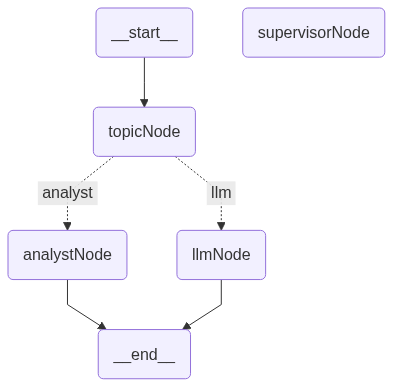

In [171]:
app

Here ..the `supervisor` in your case is **not a node** in the graph—it’s a **routing function**, a piece of logic that LangGraph uses internally to decide the next path from a node like `topicNode`

### So, You do **not** include `supervisor` as a node.

In fact, visually or structurally, it should stay **outside** the node flow—just like your diagram shows—because it doesn’t perform a computation or transformation; it simply returns a string like `"analyst"` or `"llm"` that tells LangGraph which node to jump to next.


### Recap of Roles:
- **Nodes** = actual steps that execute logic (e.g., LLM call, code execution)
- **Router Function** (like `supervisor`) = a behind-the-scenes decision-maker that controls *which* node comes next after a decision point

 We can also turn this `supervisor` logic into a classification model later for more nuanced branching



In [172]:
AgentState

__main__.AgentState

In [178]:
riders_df=pd.read_csv('MTA_Daily_Ridership.csv')
state={'df':riders_df,
       'questions':['Explain me about organic Chemistry']
        }
app.invoke(state)

-----> Topic Generator <------


OutputParserException: Invalid json output: 
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 